## 2.Atari Game Pong

**Algorithms used in this task**:

DQN, or Deep Q-Network, the deep learning algorithm based on the Q-values, with 3 convolutional layers (and the possibility to explicitly change the Network architecture), ReLU activation and adam optimizer.

**Preprocessing**:

The actual observations were given by the frames of what is happening in the game, so the frame preprocessing was needed, and it was done with the help of cv2 (opencv-python) library (resizing and normalizing pixel values). Also, the environment Pong's method reset and step were used to get the observations and iteratively play episodes one by one.

**Training**:

Was done iteratively, and took a valuable amount of time. Training and testing was done with two sets of hyperparameters and compared. Different numbers of episodes gave different average rewards, and several hours to days of training were needed to get the model which was able to beat the environment's stock player.

**Results**:

Can be seen on the 2 gifs at the end, where two seemingly best models achieved by hours of training with different hyperparameters show their performance. The comparison of their moves (second one has the ability to power-shoot the ball to increase it's speed, while first one only plays fairly and has more moderate performance) is evident.

**Conclusion**:

The task of training DQN to process the frame-based observations has a drawback of the long period of training, however it has a good perfomance on the models trained the longest time. They learn tricks and show their skills in the test games. Also, trained models (their parameters and weights) can be saved for the later usage.

In [ ]:
!pip install ale-py
!pip install gym[accept-rom-license]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 15.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 7.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for AutoROM.accept-rom-license: filename=AutoROM.accept_rom_license-0.6.1-py3-none-any.whl size=446660 sha256=a63cc9852d53f8c580a8d7a5165a203714c469c0fa2a11273e97156fc4a62fe9
  Stored in directory: /root/.cache/pip/wheels/6b/1b/ef/a43ff1a2f1736d5711faa1ba4c1f61be1131b8899e6a057811
Successfully built AutoROM.accept-rom-license


In [ ]:
import random
from collections import deque, namedtuple

import cv2
import gym
import numpy as np
from keras.layers import Conv2D, Flatten, Dense
from keras.models import Sequential
from keras.models import load_model
from keras.optimizers import Adam

conv = namedtuple('Conv', 'filter kernel stride')

KeyboardInterrupt: ignored

In [ ]:
class Buffer:
    def __init__(self, size):
        """
        Constructor for the Buffer class.
        :param size: the maximum size of the buffer
        """
        self.size = size
        self.buffer = deque()

    def add(self, s, a, r, s2, t):
        """
        Adds a new experience to the buffer.
        :param s: the current state of the environment
        :param a: the action taken by the agent
        :param r: the reward received for taking action a in state s
        :param s2: the new state of the environment after taking action a in state s
        :param t: a flag indicating whether the episode has ended
        """
        # Convert the states from a list to a three-dimensional array
        s = np.stack((s[0], s[1], s[2], s[3]), axis=2)
        s2 = np.stack((s2[0], s2[1], s2[2], s2[3]), axis=2)

        # Add the new experience to the buffer
        if len(self.buffer) < self.size:
            # If the buffer is not yet full, add the new experience to the beginning of the buffer
            self.buffer.appendleft((s, a, r, s2, t))
        else:
            # If the buffer is full, remove the oldest# experience and add the new one to the beginning of the buffer
            self.buffer.pop()
            self.buffer.appendleft((s, a, r, s2, t))

    def sample(self, batch_size):
        """
        Selects a random batch of experiences from the buffer.
        :param batch_size: the size of the batch to select
        :return: a list of random experiences, represented as tuples (s, a, r, s2, t)
        """
        return random.sample(self.buffer, batch_size)


class DQN:
    # def __init__(self, buff, batch_size=128, min_buff=5000, gamma=0.87, learning_rate=1.4e-4): - the worst set of parameters
    def __init__(self, buff, batch_size=32, min_buff=10000, gamma=0.99, learning_rate=2.5e-4):
        """
        Constructor for the DQN class.
        :param buff: the experience replay buffer
        :param batch_size: the batch size to use for training
        :param min_buff: the minimum size of the buffer required to start training
        :param gamma: the discount factor for future rewards
        :param learning_rate: the learning rate for the neural network
        """
        self.buffer = buff
        self.min_buffer = min_buff
        self.batch_size = batch_size
        self.gamma = gamma

        # Create the neural network models
        self.model = create_network(learning_rate)
        self.target_model = create_network(learning_rate)

        # Copy the weights from the model to the target model
        self.copy_network()

    def train(self):
        """
        Trains the neural network using a batch of experiences sampled from the buffer.
        """
        if len(self.buffer.buffer) >= self.min_buffer:
            # Sample a batch of experiences from the buffer
            states, actions, rewards, next_states, terminal = map(np.array, zip(*self.buffer.sample(self.batch_size)))

            # Calculate the target Q-values for the next states
            next_state_action_values = np.max(self.target_model.predict(next_states), axis=1)

            # Update the Q-values for the current states
            targets = self.model.predict(states)
            targets[range(self.batch_size), actions] = rewards + self.gamma * next_state_action_values * np.invert(
                terminal)
            self.model.train_on_batch(states, targets)

    def copy_network(self):
        """
        Copies the weights from the model to the target model.
        """
        for l_tg, l_sr in zip(self.target_model.layers, self.model.layers):
            wk = l_sr.get_weights()
            l_tg.set_weights(wk)

    def predict(self, x):
        """
        Predicts the Q-values for a given state using the model.
        :param x: the state to predict the Q-values for
        :return: the Q-values for the given state
        """
        return self.model.predict(np.array([np.stack((x[0], x[1], x[2], x[3]), axis=2)]))


def create_network(learning_rate, conv_info=[conv(32, 8, 4), conv(64, 4, 2), conv(64, 3, 1)], dense_info=[512],
                   input_size=(80, 80, 4)):
    """
        Creates a neural network model for the DQN algorithm.
        :param learning_rate: the learning rate for the optimizer
        :param conv_info: a list of tuples specifying the number of filters, kernel size, and stride for each convolutional layer
        :param dense_info: a list of integers specifying the number of units for each dense layer
        :param input_size: a tuple specifying the shape of the input
        :return: a compiled Keras neural network model
        """
    model = Sequential()
    # Add the convolutional layers to the model
    for i, cl in enumerate(conv_info):
        if i == 0:
            # For the first convolutional layer, specify the input shape
            model.add(Conv2D(cl[0], cl[1], padding="same", strides=cl[2], activation="relu", input_shape=input_size))
        else:
            # For subsequent convolutional layers, do not specify the input shape
            model.add(Conv2D(cl[0], cl[1], padding="same", strides=cl[2], activation="relu"))

    # Flatten the output from the convolutional layers
    model.add(Flatten())

    # Add the dense layers to the model
    for dl in dense_info:
        model.add(Dense(dl, activation="relu"))

    # Add the output layer to the model with 6 units (one for each possible action)
    model.add(Dense(6))

    # Compile the model with the mean squared error loss and the Adam optimizer
    adam = Adam(lr=learning_rate)
    model.compile(loss='mse', optimizer=adam)

    return model


class Pong:
    def __init__(self):
        self.env = gym.make('Pong-v0')
        self.epsilon = 1
        self.buffer = Buffer(50000)
        self.dqn = DQN(self.buffer)
        self.copy_period = 40000
        self.itr = 0
        self.eps_step = 1e-4
        # The set of parameters which had worse perfomance
        # self.epsilon = 0.89
        # self.buffer = Buffer(25000)
        # self.copy_period = 10000
        # self.eps_step = 0.000009

    def sample_action(self, s):
        return np.argmax(self.dqn.predict(s)[0]) if random.random() >= self.epsilon else self.env.action_space.sample()

    def play_one_episode(self):
        observation = self.env.reset()
        done = False
        state = []
        update_state(state, observation)
        prv_state = []
        total_reward = 0
        while not done:

            if len(state) < 4:
                action = self.env.action_space.sample()
            else:
                action = self.sample_action(state)

            prv_state.append(state[-1])
            if len(prv_state) > 4:
                prv_state.pop(0)
            observation, reward, done, _ = self.env.step(action)

            update_state(state, observation)
            if len(state) == 4 and len(prv_state) == 4:
                self.buffer.add(prv_state, action, reward, state, done)
            total_reward += reward

            self.itr += 1
            if self.itr % 4 == 0:
                self.dqn.train()
            self.epsilon = max(0.1, self.epsilon - self.eps_step)
            if self.itr % self.copy_period == 0:
                self.dqn.copy_network()
        return total_reward


def downsample(observation):
    """
    Resizes and normalizes the input image for the DQN algorithm.
    :param observation: the input image from the environment
    :return: the resized and normalized image as a numpy array
    """
    s = observation[0][6]
    s = cv2.resize(s, (80, 80), interpolation=cv2.INTER_AREA)
    s = s / 255.0
    return s


def update_state(state, observation):
    """
    Updates the state with a new observation from the environment.
    :param state: a list containing the previous four observations
    :param observation: the current observation from the environment
    """
    ds_observation = downsample(observation)
    state.append(ds_observation)
    if len(state) > 4:
        state.pop(0)


def sample_action(model, s):
    """
    Samples an action from the model's output Q-values for a given state.
    :param model: the DQN model
    :param s: the current state of the environment
    :return: the action with the highest Q-value for the given state
    """
    return np.argmax(model.predict(np.array([np.stack((s[0], s[1], s[2], s[3]), axis=2)]))[0])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Create a Pong environment object
p = Pong()
# Initialize the maximum reward to a very low value
max_reward = -10 ** 9
for i in range(15):
    # Play one episode of Pong and get the total reward
    total_reward = p.play_one_episode()
    print(f'{i} episode total reward: {total_reward}')
    # If the total reward is greater than the maximum reward seen so far, save the model
    if total_reward > max_reward:
        print("Saving the model")
        p.dqn.model.save("model.h5")
        max_reward = total_reward

/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment Pong-v0 is out of date. You should consider upgrading to version `v4`.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/usr/local/lib/pytho

Выходные данные были обрезаны до нескольких последних строк (5000).
1/1 [==============================] - 0s 28ms/step
6 episode total reward: -21.0
4/4 [==============================] - 0s 40ms/step
7 episode total reward: -20.0
4/4 [==============================] - 0s 42ms/step
8 episode total reward: -20.0
4/4 [==============================] - 0s 43ms/step
9 episode total reward: -21.0
1/1 [==============================] - 0s 30ms/step
10 episode total reward: -21.0
4/4 [==============================] - 0s 52ms/step
11 episode total reward: -18.0
Saving the model
4/4 [==============================] - 0s 55ms/step


In [ ]:
# Create a Pong environment using OpenAI Gym
env = gym.make('Pong-v0', render_mode='human')
# Load the best model obtained during training
model = load_model('model.h5')
# Initialize the game loop variables
done = False
truncated = False
state = []
observation = env.reset()[0]
# Update the state with the initial observation
update_state(state, observation)

while not done and not truncated:
    env.render()
    # Select an action to take based on the current state
    if len(state) < 4:
        action = env.action_space.sample()
    else:
        action = sample_action(model, state)
    observation, reward, done, truncated, _ = env.step(action)
    update_state(state, observation)

RuntimeError: ignored

This is the model, that trained on the worst parameters

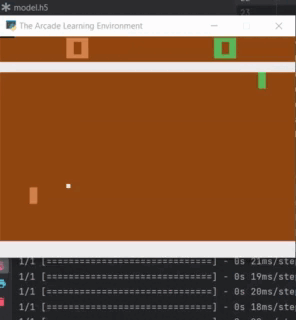


This is the model that trained on the best parameters

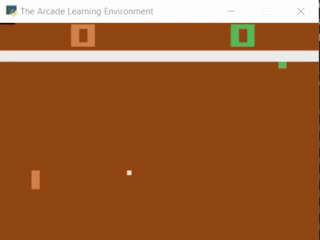